# Proyecto 3 Visión por Computadora

In [27]:
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
import timeit
import os

## Inciso 1

In [28]:

def loadImages(path, resize):
    """Load Images from path to array, @param path is the folder which containing images, @param resize is True
    if image is halved in size, otherwise is False"""
    image_path = sorted(list(paths.list_images(path)))
    list_image = []
    for _, j in enumerate(image_path):
        image = cv2.imread(j)
        if resize == 1:
            image = cv2.resize(
                image, (int(image.shape[1] / 4), int(image.shape[0] / 4))
            )
        list_image.append(image)
    return list_image

In [29]:
descriptors = []
correspondences = []

## Inciso 2

In [30]:
def getHomography(src_img, dst_img, ransacRep=5.0):

    src_kp, src_features = findAndDescribeFeatures(src_img)
    dst_kp, dst_features = findAndDescribeFeatures(dst_img)

    good = matchFeatures(src_features, dst_features)

    src_points = np.float32([src_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_points = np.float32([dst_kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, ransacRep)
    matchesMask = mask.ravel().tolist()
    matches = drawMatches(src_img, src_kp, dst_img, dst_kp, good, matchesMask)
    correspondences.append(matches)
    return H, matchesMask



def findAndDescribeFeatures(image, opt="ORB"):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if opt == "SURF":
        md = cv2.xfeatures2d.SURF_create()
    if opt == "ORB":
        md = cv2.ORB_create(nfeatures=3000)
    if opt == "SIFT":
        md = cv2.xfeatures2d.SIFT_create()

    keypoints, features = md.detectAndCompute(grayImage, None)

    features = np.float32(features)
    keypoints_img = drawKeypoints(image, keypoints)
    descriptors.append(keypoints_img)
    return keypoints, features


def matchFeatures(featuresA, featuresB, ratio=0.75):
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    featureMatcher = cv2.FlannBasedMatcher(index_params, search_params)

    matches = featureMatcher.knnMatch(featuresA, featuresB, k=2)

    good = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    if len(good) > 4:
        return good
    raise Exception("No hay suficientes matches")


def drawKeypoints(img, kp):
    img1 = img.copy()
    cv2.drawKeypoints(img, kp, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img1


def drawMatches(src_img, src_kp, dst_img, dst_kp, matches, matchesMask):
    draw_params = dict(
        matchColor=(0, 255, 0),  # draw matches in green color
        singlePointColor=None,
        matchesMask=matchesMask[:100],  # draw only inliers
        flags=2,
    )
    return cv2.drawMatches(
        src_img, src_kp, dst_img, dst_kp, matches[:100], None, **draw_params
    )

## Inciso 3

In [31]:
def warp(src_img, dst_img, showstep=False):
    # generate Homography matrix
    H, _ = getHomography(src_img, dst_img)

    height_src, width_src = src_img.shape[:2]
    height_dst, width_dst = dst_img.shape[:2]

    pts1 = np.float32(
        [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
    ).reshape(-1, 1, 2)
    pts2 = np.float32(
        [[0, 0], [0, height_dst], [width_dst, height_dst], [width_dst, 0]]
    ).reshape(-1, 1, 2)

    try:
        pts1_ = cv2.perspectiveTransform(pts1, H)
        pts = np.concatenate((pts1_, pts2), axis=0)

        [xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
        [_, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
        t = [-xmin, -ymin]

        if pts[0][0][0] < 0:
            side = "left"
            width_pano = width_dst + t[0]
        else:
            width_pano = int(pts1_[3][0][0])
            side = "right"
        height_pano = ymax - ymin

        Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
        src_img_warped = cv2.warpPerspective(
            src_img, Ht.dot(H), (width_pano, height_pano)
        )

        dst_img_rz = np.zeros((height_pano, width_pano, 3))
        if side == "left":
            dst_img_rz[t[1] : height_src + t[1], t[0] : width_dst + t[0]] = dst_img
        else:
            dst_img_rz[t[1] : height_src + t[1], :width_dst] = dst_img

        pano, nonblend, leftside, rightside = blending(
            dst_img_rz, src_img_warped, width_dst, side, showstep=showstep
        )

        # croping black region
        pano = crop(pano, height_dst, pts)
        return pano, nonblend, leftside, rightside
    except BaseException:
        raise Exception("No funcionó")


def multiStitching(list_images):
    n = int(len(list_images) / 2 + 0.5)
    left = list_images[:n]
    right = list_images[n - 1 :]
    right.reverse()
    while len(left) > 1:
        dst_img = left.pop()
        src_img = left.pop()
        left_pano, _, _, _ = warp(src_img, dst_img)
        left_pano = left_pano.astype("uint8")
        left.append(left_pano)

    while len(right) > 1:
        dst_img = right.pop()
        src_img = right.pop()
        right_pano, _, _, _ = warp(src_img, dst_img)
        right_pano = right_pano.astype("uint8")
        right.append(right_pano)


    # if width_right_pano > width_left_pano, Select right_pano as destination. Otherwise is left_pano
    if right_pano.shape[1] >= left_pano.shape[1]:
        fullpano, _, _, _ = warp(left_pano, right_pano)
    else:
        fullpano, _, _, _ = warp(right_pano, left_pano)
    return fullpano


def crop(panorama, h_dst, conners):
    [xmin, ymin] = np.int32(conners.min(axis=0).ravel() - 0.5)
    t = [-xmin, -ymin]
    conners = conners.astype(int)


    if conners[0][0][0] < 0:
        n = abs(-conners[1][0][0] + conners[0][0][0])
        panorama = panorama[t[1] : h_dst + t[1], n:, :]
    else:
        if conners[2][0][0] < conners[3][0][0]:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[2][0][0], :]
        else:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[3][0][0], :]
    return panorama


## Inciso 4

In [32]:
def blendingMask(height, width, barrier, smoothing_window, left_biased=True):
    assert barrier < width
    mask = np.zeros((height, width))

    offset = int(smoothing_window / 2)
    try:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset + 1).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset + 1).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1
    except BaseException:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1

    return cv2.merge([mask, mask, mask])


def blending(dst_img_rz, src_img_warped, width_dst, side, showstep=False):
   
    h, w, _ = dst_img_rz.shape
    smoothing_window = int(width_dst / 8)
    barrier = width_dst - int(smoothing_window / 2)
    mask1 = blendingMask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=True
    )
    mask2 = blendingMask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=False
    )

    if showstep:
        nonblend = src_img_warped + dst_img_rz
    else:
        nonblend = None
        leftside = None
        rightside = None

    if side == "left":
        dst_img_rz = cv2.flip(dst_img_rz, 1)
        src_img_warped = cv2.flip(src_img_warped, 1)
        dst_img_rz = dst_img_rz * mask1
        src_img_warped = src_img_warped * mask2
        pano = src_img_warped + dst_img_rz
        pano = cv2.flip(pano, 1)
        if showstep:
            leftside = cv2.flip(src_img_warped, 1)
            rightside = cv2.flip(dst_img_rz, 1)
    else:
        dst_img_rz = dst_img_rz * mask1
        src_img_warped = src_img_warped * mask2
        pano = src_img_warped + dst_img_rz
        if showstep:
            leftside = dst_img_rz
            rightside = src_img_warped

    return pano, nonblend, leftside, rightside


In [33]:
def plot_images(images, titles, rows, cols, figsize=(20, 20)):
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axs.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(titles[i])
            ax.axis("off")
    plt.tight_layout()
    plt.show()

Complete!


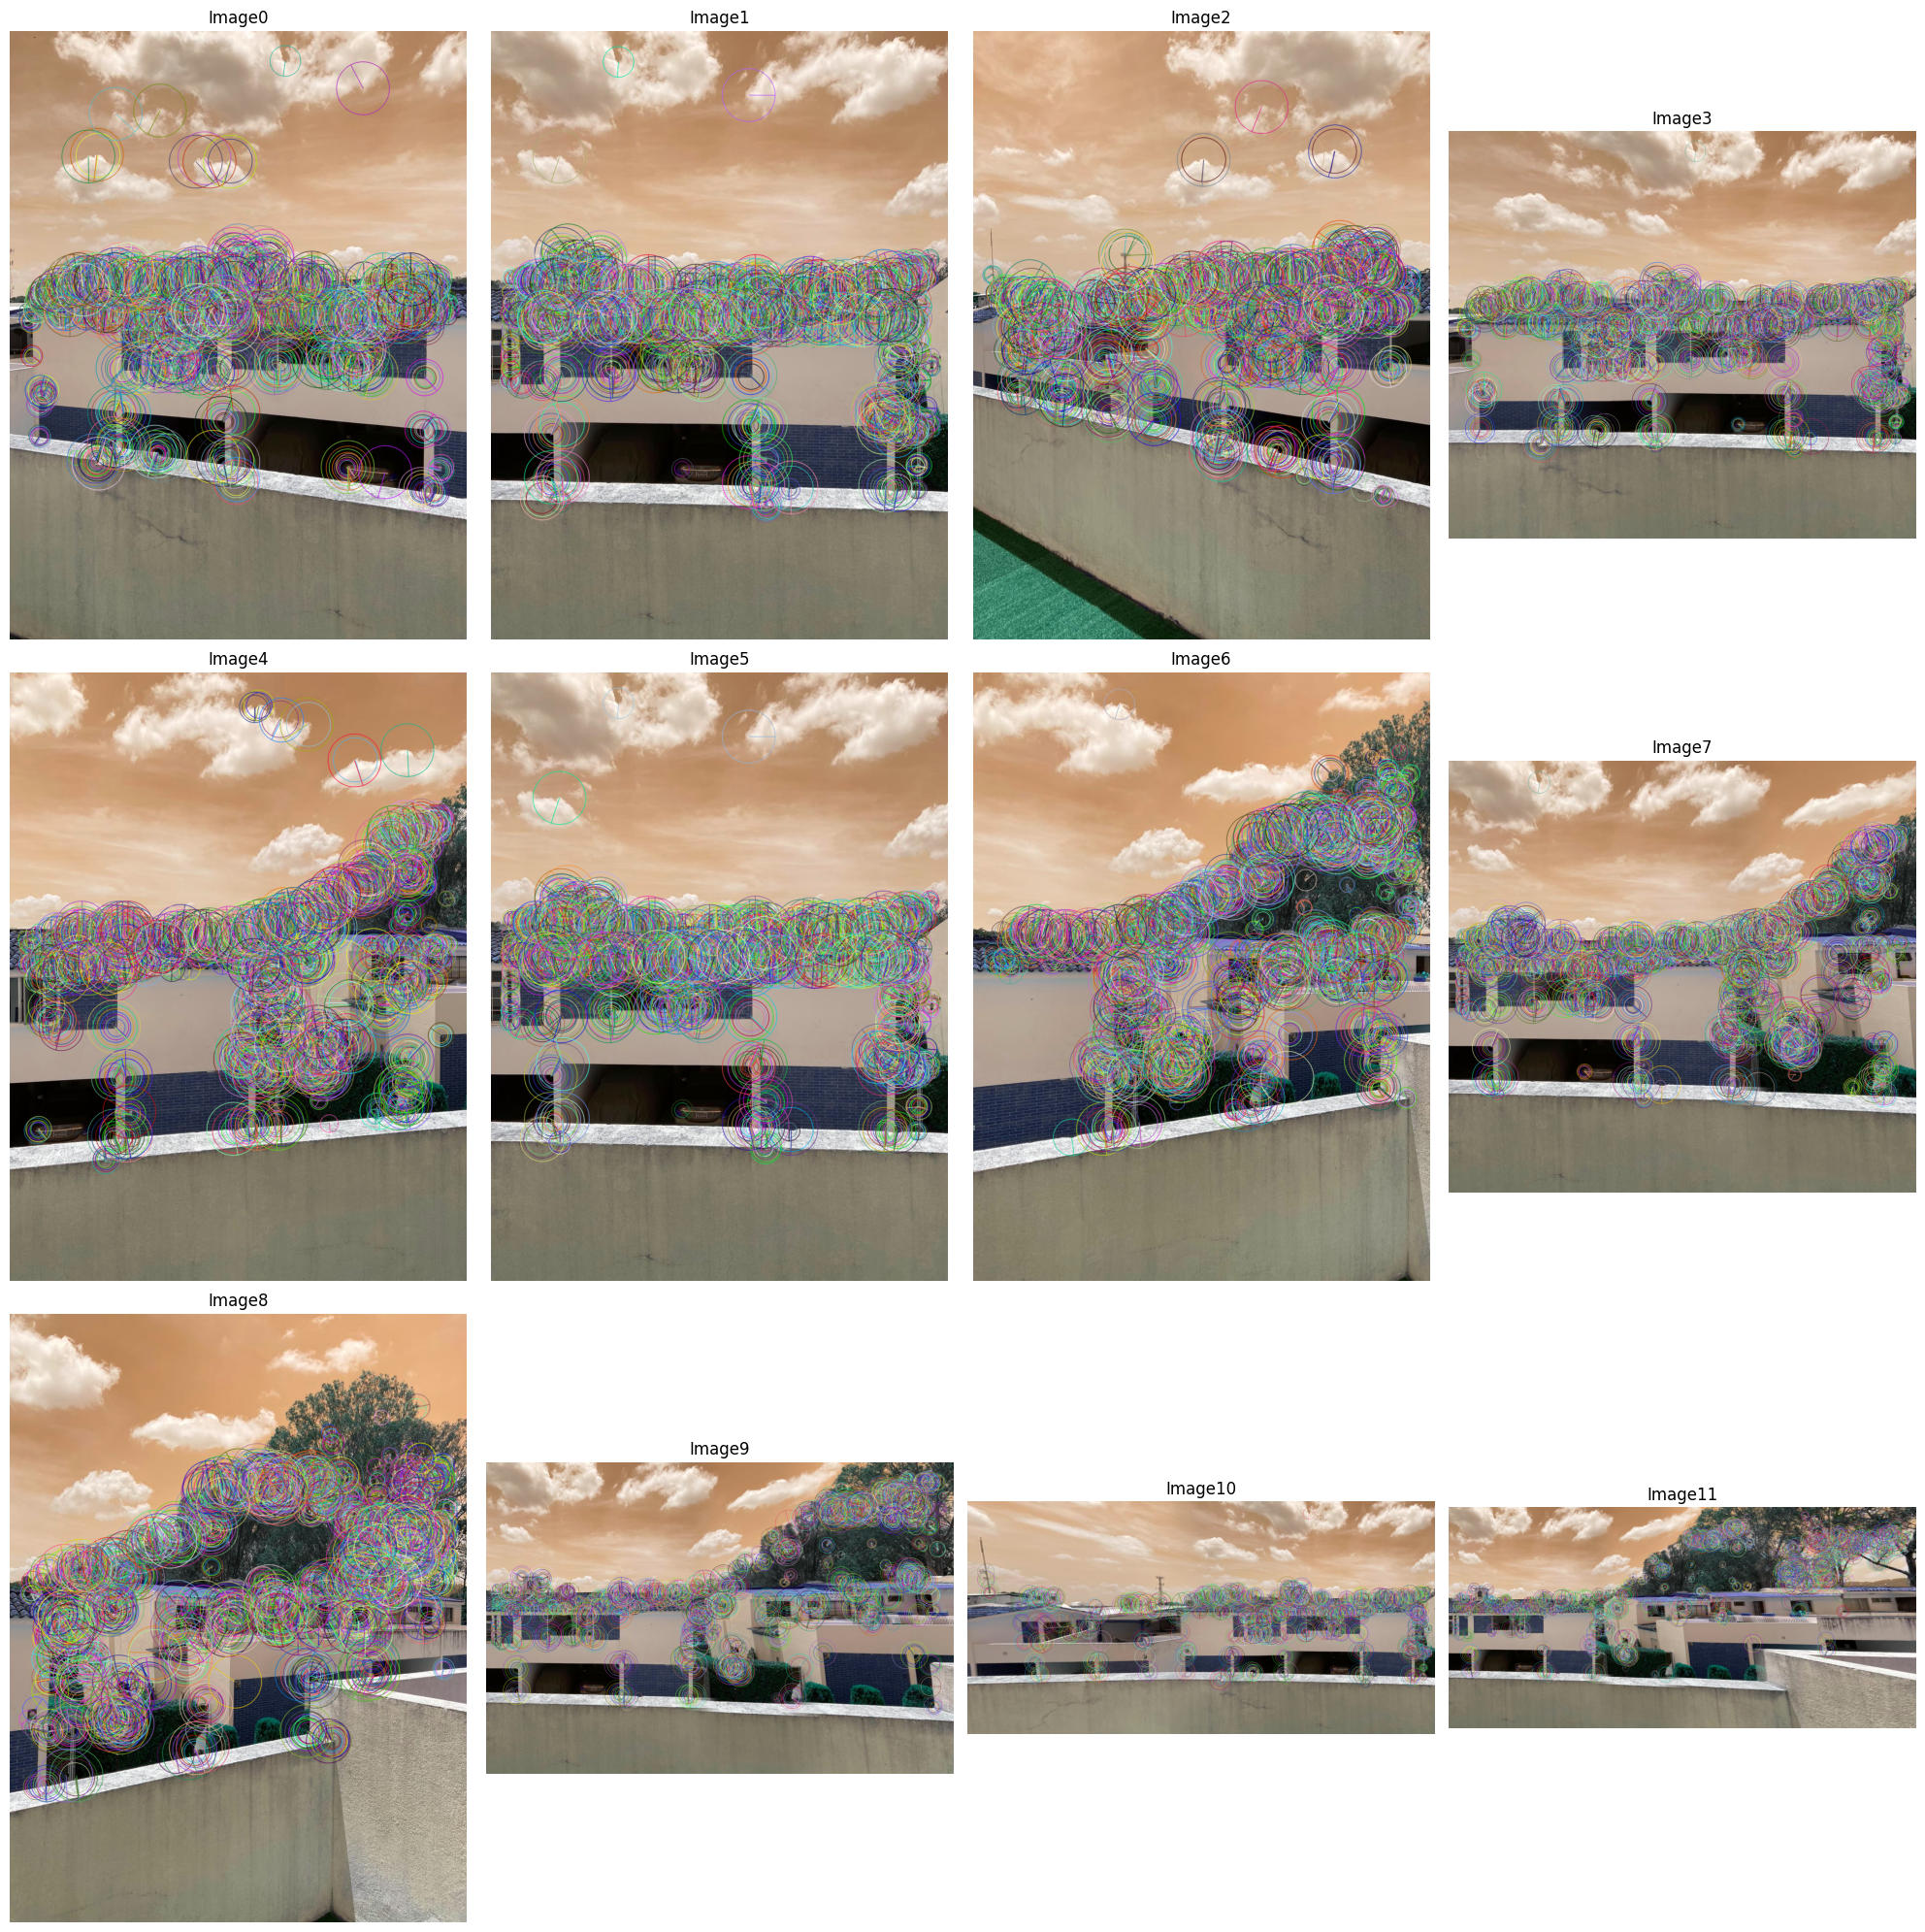

In [34]:
input = './prueba2'
output = './output'
resize = 2


# load images
list_images = loadImages(input, resize)

# create panorama, default using ORB with nfeatures=3000, u can change to SIFT, SURF in features.py or add some argument
panorama = multiStitching(list_images)

# save
if output:
    cv2.imwrite(os.path.join(output, "result.jpg"), panorama)
else:
    cv2.imwrite("result2.jpg", panorama)

print("Complete!")

# plot images
#descriptors = descriptors[:len(descriptors) // 2]
rows = np.sqrt(len(descriptors)).astype(int)
cols = np.ceil(len(descriptors) / rows).astype(int)
plot_images(descriptors, ["Image" + str(i) for i in range(len(descriptors))], rows, cols)

rows = np.sqrt(len(correspondences)).astype(int)
cols = np.ceil(len(correspondences) / rows).astype(int)
plot_images(correspondences, ["Image" + str(i) for i in range(len(correspondences))], rows, cols)